# Project 2 - Forecast correction

## General Overview

### Understand Assignment
https://www.ecmwf.int/en/newsletter/166/meteorology/statistical-post-processing-ensemble-forecasts-belgian-met-service
- Given 2023 discrepancies between forecast and actual values, what will the temperatures be at the vlinder station in 2024?
    - Seems that temperaturs at vlinder station tend to be hotter than the forecast

- The ensemble mean of the corrected forecast is a linear function of the ensemble mean(s) of the predictor(s)
- direct output from computer simulations of the atmosphere needs calibration before it can be meaningfully compared with observations of weather variables. This calibration process is often known as model output statistics (MOS). The simplest form of such calibration is to correct biases, using a bias correction calculated from past forecast errors

### Data Preprocessing
- [x] Add data from all the forecasts of 2023
    - We dont especially need to avoid duplicate data, we can keep it
- [ ] Use past data pf 2024 to add to training data
- What data do we keep for selection [Feature Selection](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)?
    - Data selection will depend on algo used
        - We need to create a dataframe that holds all the different forecasts grouped by start date. We can then combine them as required for the different ML algorithmes. We need to do the train/validation/test sets as earlier as possible, in order to validate our algorithmes on the same data. (does this actually matter ?)   
    - correlation analysis/feature importance ranking/Principal Component Analysis 
    - At what level of correletion do i keep my values?
    - Simple regression on t2m sufficient?
- Sync data: vlinder:
    - [x] need same time frame than Forecast -> need a way to get it directly from the max and min of forecast csv
    - [x] merge because of time stamps (do i take the mean of tmp on elapsed period or precise timestamp ?)
- How to treat small vlinder data set?
- Rounding errors in ecmwf t2m data?
- RandomForest Regressor
- Nonhomogeneous Gaussian regression

### Algo/training

- Look at the difference from one day to the other in forecast (instead of computing absolute values)
- Use the difference between forecast tmp and predicted temp to analyze other variables (heat island effect)
- Use a Neural net where inputs are different timestamps for each forecast

### Nice things to have
- [ ] Use pipelines to automate operations
- [x] Consumption of energy + log
- [ ] Time function (+ display number of training samples) 

### Misc
- Name of station ? ecmwf? station?
- All of the data visualization is happening on the whole set, no split atm probably not good

In [1]:
%pip install codecarbon

Note: you may need to restart the kernel to use updated packages.


In [2]:
from codecarbon import track_emissions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import glob
import datetime
from functools import partial
# 0 degre Celius in Kelvin
C_0 = 273.15
#Dict to link target metrics from forecast with an eventual required scaling constant
Const_Conversion = {'t2m' : C_0, 'd2m' : C_0, 'skt' : C_0}
plt.style.use('seaborn-v0_8-colorblind')

#from https://stackoverflow.com/questions/16739290/composing-functions-in-python
def compose (*functions):
    """
        Enables function composition
    """
    def inner(arg):
        for f in reversed(functions):
            arg = f(arg)
        return arg
    return inner

# Match data sets
Need to resample data from the vlinder station to match the measurements of the forecast.
- We add all the different forecasts in one dataframe
    - Need to be carefull with duplicate data (does it matter to take the days of the same ensemble forecast?) 
- Resample on frequency, vlinder measures every 5 minutes where as the forecast is given for every 6 hours
- Resize on time frame, we need our ensemble forecast timestamps to match measurements at vlinder station
    - Need to match data of vlinder station

## Forecast data sets

In [10]:
# Create of Main DataFrame
class EnsembleForecast:
    def __init__(self):
        self.df = self._create_df()

    def _extract_datetime(self, file_name):
        """
            Extracts datetime object from file_name 
            Returns datetime if successful, None otherwise
        """
        try:
            strings_of_date = file_name.replace('.', '_').split('_')[1:4]
            d, m, y = tuple(map(int, strings_of_date))
            return datetime.datetime(y, m, d)
        except Exception as e:
            print(f"Forecast csv does not respect date_month_year.csv format: {e}\n {file_name} dropped")
        return None


    # TODO: create multi index on start time and then on forecast time
    def _create_df(self):
        """
            Creates dataframe where each ensemble forecast is accessible by its start date
        """
        df_f = pd.DataFrame()
        for file_name in glob.glob("forecast/"+'*.csv'): 
            start_time = self._extract_datetime(file_name)
            if start_time != None:
                to_add = pd.read_csv(file_name)
                to_add['Start'] = start_time
                df_f = pd.concat([df_f, to_add])
            else:
                pass
        self.time_str = df_f.columns.to_list()[0]
        df_f = df_f.sort_values(by='Start', kind='mergesort')
        return df_f.set_index(['Start', 'time']).sort_index()

    def get_df(self):
        return self.df

    def get_min_max(self):
        """
            Returns earliest and latest date available in the ensemble forecasts
        """
        select_time = self.df.index.get_level_values('time')
        return (select_time.min(), select_time.max())
        
    def get_start_dates(self):
        """
            Returns a list start date of ensemble forecast
        """
        lst = list(set(self.df.index.get_level_values('Start')))
        lst.sort()
        return lst

    def get_ensemble_forecast(self, date):
        """
            Returns ensemble forecast given date
            date format (%Y-%M-%D %h:%m:%s)
        """
        return self.df.loc[date]

forecast_data = EnsembleForecast()

forecast_min, forecast_max = forecast_data.get_min_max()
print(forecast_data.get_min_max())

df_1 = forecast_data.get_ensemble_forecast("2023-03-01 00:00:00")
df_all = forecast_data.get_df()
df_all

('2023-03-01 00:00:00', '2023-07-07 00:00:00')


number  latitude  longitude     cape  \
Start      time                                                        
2023-03-01 2023-03-01 00:00:00       1     50.75       4.25  0.00000   
           2023-03-01 00:00:00       2     50.75       4.25  0.00000   
           2023-03-01 00:00:00       3     50.75       4.25  0.00000   
           2023-03-01 00:00:00       4     50.75       4.25  0.00000   
           2023-03-01 00:00:00       5     50.75       4.25  0.00000   
...                                ...       ...        ...      ...   
2023-06-30 2023-07-07 00:00:00      46     50.75       4.25  0.00000   
           2023-07-07 00:00:00      47     50.75       4.25  8.89032   
           2023-07-07 00:00:00      48     50.75       4.25  0.00000   
           2023-07-07 00:00:00      49     50.75       4.25  0.00000   
           2023-07-07 00:00:00      50     50.75       4.25  0.00000   

                                        sp        tcw        sshf        slhf  \
Start      time                                                                 
2023-03-01 2023-03-01 00:00:00  102126.210   6.714889      -117.5      -127.0   
           2023-03-01 00:00:00  102133.650   6.498146      -117.5      -127.0   
           2023-03-01 00:00:00  102119.945   6.799605      -117.5      -127.0   
           2023-03-01 00:00:00  102120.590   7.023780      -117.5      -127.0   
           2023-03-01 00:00:00  102109.240   6.827844      -117.5      -127.0   
...                                    ...        ...         ...         ...   
2023-06-30 2023-07-07 00:00:00  101233.460  14.589812 -16156415.0 -69784060.0   
           2023-07-07 00:00:00  101112.016  22.093838 -21840656.0 -65307064.0   
           2023-07-07 00:00:00  101039.340  21.153736 -18487710.0 -67841460.0   
           2023-07-07 00:00:00  101245.240  19.395767 -17201248.0 -62672096.0   
           2023-07-07 00:00:00  101189.170  17.802002 -19434140.0 -63742224.0   

                                       msl       u10  ...        skt  \
Start      time                                       ...              
2023-03-01 2023-03-01 00:00:00  103096.090 -0.985653  ...  269.20410   
           2023-03-01 00:00:00  103103.970 -1.522217  ...  269.66020   
           2023-03-01 00:00:00  103089.580 -1.284668  ...  269.31256   
           2023-03-01 00:00:00  103091.086 -1.273917  ...  269.56317   
           2023-03-01 00:00:00  103079.080 -1.361147  ...  269.51580   
...                                    ...       ...  ...        ...   
2023-06-30 2023-07-07 00:00:00  102098.090  1.366186  ...  283.57922   
           2023-07-07 00:00:00  101972.410  1.733405  ...  287.58844   
           2023-07-07 00:00:00  101893.620 -2.314096  ...  287.27180   
           2023-07-07 00:00:00  102105.445 -1.956505  ...  285.15800   
           2023-07-07 00:00:00  102050.620  1.571266  ...  284.66727   

                                     cin         sm         st   sd   sf  \
Start      time                                                            
2023-03-01 2023-03-01 00:00:00       NaN  347.42044  275.79584  0.0  0.0   
           2023-03-01 00:00:00       NaN  338.56020  275.89400  0.0  0.0   
           2023-03-01 00:00:00       NaN  350.98910  275.68307  0.0  0.0   
           2023-03-01 00:00:00       NaN  358.10077  275.86673  0.0  0.0   
           2023-03-01 00:00:00       NaN  340.47208  275.64920  0.0  0.0   
...                                  ...        ...        ...  ...  ...   
2023-06-30 2023-07-07 00:00:00       NaN  267.03625  290.64008  0.0  0.0   
           2023-07-07 00:00:00 -7.350601  220.22717  291.70862  0.0  0.0   
           2023-07-07 00:00:00       NaN  254.99454  291.69858  0.0  0.0   
           2023-07-07 00:00:00       NaN  278.80988  291.07452  0.0  0.0   
           2023-07-07 00:00:00       NaN  234.71643  290.46548  0.0  0.0   

                                      tcc            tp      mx2t6      mn2t6  
Start      time                    

## Vlinder Data

Vlinder data set is inside a Vlinder class. This makes it easier to query and display subsets of data

We need to check for inconsitent data points in the the vlinder set and then resample it to match the ensemble forecast

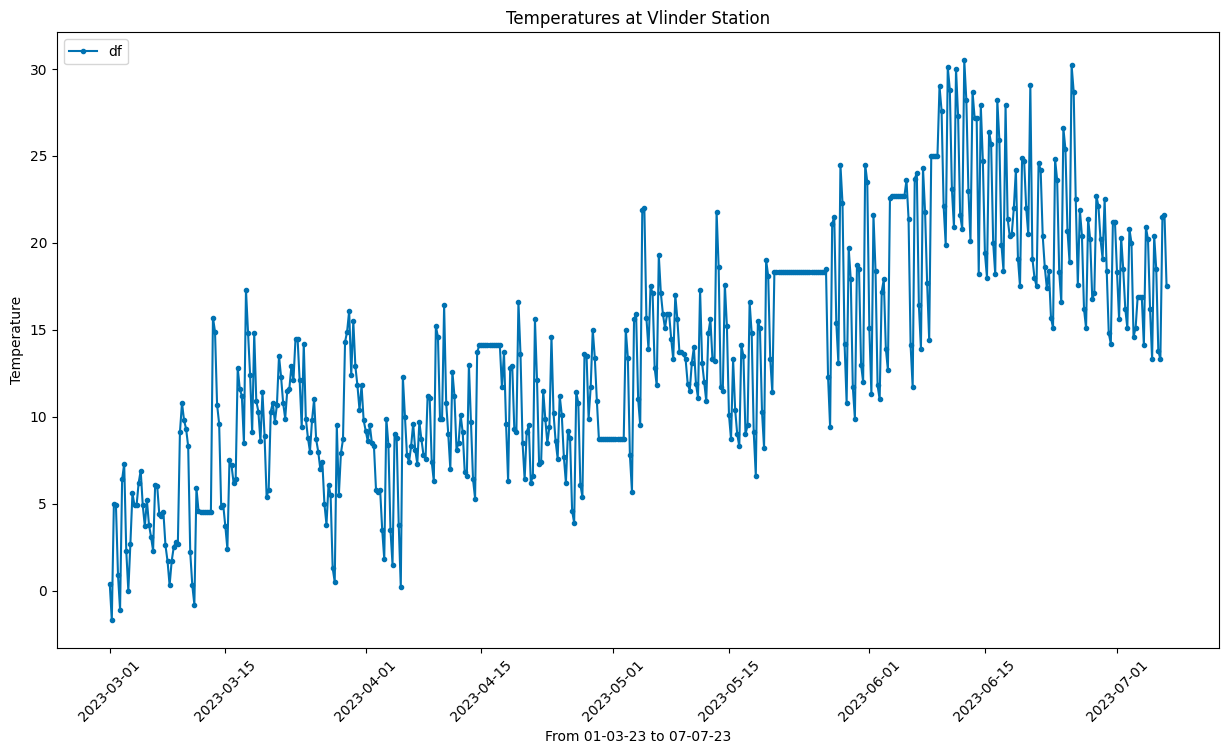

In [12]:
#TODO: could also modify resampling rate to make it more modular 
class Vlinder: 
    """
        Class that represents Vlinder data
        Holds original data in self.df 
        Holds resampled data in self.resample
    """
    
    def __init__(self, path_to_csv):
        self.df = pd.read_csv(path_to_csv)
        self.temp_str = self.df.columns.tolist()[0]
        self.time_str = self.df.columns.tolist()[1]
        self.df[self.time_str] = pd.to_datetime(self.df[self.time_str])
        self.resample = {"first" :  self.df.set_index(self.time_str).resample('6h').first().reset_index(),
                        "mean" : self.df.set_index(self.time_str).resample('6h').mean().reset_index()}

    def apply_dates_resize(self, first, snd):
        """
            Does a partial application of dates as we often want the same dates for different dataframes
        """
        return partial(self.resize_on_time, start=first, finish=snd)

    #TODO refactore horrible code
    def _get_time(self, df, start, finish):
        """
            Helper function to set start and finish to the min
            Start and finish can be either None, string or datetime
            Returns datetime object
        """
        if start is None: 
            start = self.earliest(df)
        elif isinstance(start, str):
            start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        else: 
            pass
        if finish is None: 
            finish = self.latest(df) 
        elif isinstance(finish, str):
            finish = datetime.datetime.strptime(finish, "%Y-%m-%d %H:%M:%S")
        else:
            pass
        return (start, finish)
        
    
    def dataframe_of_string(func):
        """
            Decorator function used to convert input dataframe string into actual dataframe
            If passed in argument is already a dataframe does nothing and passes data framethrough
            Carefull: input type is a string, new type is a dataframe
        """
        def wrapper(self, type="df", *args, **kwargs):
            if isinstance(type, str):
                type = self.select_type(type)
            return func(self, type, *args, **kwargs)
        return wrapper

    #Does not work well when chaining decorators together => Unused atm
    def handle_time(func):
        """
            Decorator used to handle start and finish times
        """
        def wrapper(self, *args, **kwargs):
            if start is None:
                start = self.earliest()
            if finish is None:
                finish = self.latest()
            return func(self, df, start, finish, *args, **kwargs)
        return wrapper

    
    def select_type(self, type="df"):
        """
            Returns dataframe corresponding to type
            types available: 
            - df : original dataframe
            - mean : dataframe resampled on mean
            - first : dataframe resampled on first
        """
        df = None
        match type:
            case "df":
                df = self.df
            case "mean":
                df = self.resample["mean"]
            case "first":
                df = self.resample["first"]
            case _ :
                raise ValueError(f"dataframe {type} does not exist")
        return df
    
    @dataframe_of_string
    def earliest(self, type="df"):
        """
            Returns earliest date in dataframe
        """
        return min(type[self.time_str])

    @dataframe_of_string
    def latest(self, type="df"):
        """
            Returns latest date in dataframe
        """
        return max(type[self.time_str])

    def plot(self, start=None, finish=None):
        """
            Plots original data points as well as resampeled on mean and first
        """
        start , finish = self._get_time(self.df, start, finish)

        # partial application of dates
        select_df = self.apply_dates_resize(start, finish)

        mean = select_df("mean")
        first = select_df("first")
        base = select_df("df")
        
        plt.figure(figsize=(15, 8))
        plt.plot(first[self.time_str], first[self.temp_str], label='resampled first', marker='o', markersize=2, linewidth=1)
        plt.plot(mean[self.time_str], mean[self.temp_str], label='resampled mean',  marker='s', markersize=2, linewidth=1)
        #plt.plot(base[self.time_str], base[self.temp_str], label='original', linestyle='--', linewidth=0.7)
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()
    
    @dataframe_of_string
    def plot_one(self, type="df" , start=None, finish=None):
        """
            Plots one of the dataframes, either df, mean or first
        """
        start , finish = self._get_time(type, start, finish)
        df_resize = self.resize_on_time(type, start, finish)
        plt.figure(figsize=(15, 8))
        plt.plot(df_resize[self.time_str], df_resize[self.temp_str], marker='o',  markersize=3, label="df") #cannot use type as label as it has been changed to dataframe through decorator
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()

    @dataframe_of_string
    def resize_on_time(self, type="df", start=None, finish=None):
        """
            Returns new data frame with values between start and finish
            type specifies on which dataframe to apply resizing (df for original, mean for resample mean and first for resample first)
            Format (%Y-%M-%D %h:%m:%s)
            
            On why start and finish = None: https://stackoverflow.com/questions/1802971/nameerror-name-self-is-not-defined
        """
        start , finish = self._get_time(type, start, finish)
        assert start >= self.earliest(type), f"{start} does not exist in dataframe"
        assert finish <= self.latest(type), f"{finish} dies not exist in dataframe"
        return type[(type[self.time_str] >= start) & (type[self.time_str] <= finish)]  

    @dataframe_of_string
    def drop(self, type="df", start=None, finish=None):
        """
        Drops values between [start, finish].
        If string is passed, returns new dataframe with dropped values.
        If dataframe is passed, exculdes values from that dataframe
        """
        start , finish = self._get_time(type, start, finish)
        before = type[type[self.time_str] < start]
        after = type[type[self.time_str] > finish]
        return pd.concat([before, after])

vlinder_data = Vlinder('vlinder19_2023.csv')

#Plot vlinder data on time frame of forecast date avaiable
vlinder_data.plot_one(type="first", start=forecast_min, finish=forecast_max)

We can see from our resampled data that there are multiple periods where temperature seems to be constant. This probably indicates a measument error. We will exclude all those inadequat values from our data.

We need a function that computes all constant intervals

In [61]:
from collections import defaultdict  
from itertools import chain          

vlinder_test = vlinder_data.resize_on_time(type="mean", start=forecast_min, finish=forecast_max)
def return_cst_intervals(df):
    """
        Returns start, end and timedelta of all constant intervals in our dataframe
    """
    #from https://stackoverflow.com/questions/66684957/is-there-a-faster-way-for-finding-the-range-of-constant-values-in-a-dataframe
    #Compares current element with prev, if (not equal) => True (1), else False (0). cumulative sum then adds.
    #If different sum goes up, else stays constant
    groupr = df.temp.ne(df.temp.shift()).cumsum()
    #creates group of (nb, timestamp)
    mapper = list(zip(groupr, df.datetime))
    #from https://stackoverflow.com/questions/71945206/keep-duplciate-items-in-list-of-tuples-if-only-the-first-index-matches-between-t
    dct = defaultdict(list)
    for tup in mapper:
        first, _ = tup
        dct[first].append(tup)
        onlydups = [lst for firstelem, lst in dct.items() if len(lst) > 1]
    #only dups is a list of list with duplicate items
    min_max_lst = []
    for dup in onlydups:
        start = dup[0][1]
        end = dup[-1][1]
        min_max_lst.append((start, end, end - start))
    return min_max_lst

return_cst_intervals(vlinder_test)

[(Timestamp('2023-03-12 00:00:00'),
  Timestamp('2023-03-13 00:00:00'),
  Timedelta('1 days 00:00:00')),
 (Timestamp('2023-04-14 18:00:00'),
  Timestamp('2023-04-17 00:00:00'),
  Timedelta('2 days 06:00:00')),
 (Timestamp('2023-04-29 12:00:00'),
  Timestamp('2023-05-02 00:00:00'),
  Timedelta('2 days 12:00:00')),
 (Timestamp('2023-05-20 12:00:00'),
  Timestamp('2023-05-26 06:00:00'),
  Timedelta('5 days 18:00:00')),
 (Timestamp('2023-06-03 18:00:00'),
  Timestamp('2023-06-05 00:00:00'),
  Timedelta('1 days 06:00:00')),
 (Timestamp('2023-06-08 12:00:00'),
  Timestamp('2023-06-09 00:00:00'),
  Timedelta('0 days 12:00:00')),
 (Timestamp('2023-07-03 12:00:00'),
  Timestamp('2023-07-03 18:00:00'),
  Timedelta('0 days 06:00:00'))]

In [32]:
drop_middle_vlinder_p = partial(vlinder_data.drop, start="2023-03-12 00:00:00", finish="2023-03-13 00:00:00")
drop_end_vlinder_p = partial(vlinder_data.drop, start="2023-04-14 18:00:00")

#functions that drops all above mentionned unvalid values
drop_unvalid_vlinder = compose(drop_middle_vlinder_p, drop_end_vlinder_p)

#df = vlinder_data.resize_on_time("mean", start=forecast_min, finish=forecast_max)
#df = drop_wrong_data(df)
#vlinder_data.plot_one(df)

## Integrating Forecast and Vlinder Temperaturs
1. We need to know how to resample our Vlinder Data.
   - Compute the mean of 't2m' (which will be our explanatory variable) and correlated it to the ressampled vlinder data. We then choose the highest correlated resampling method
   - We can also choose here which time period we consider
2. We can then merge ensemble forecasts with observed vlinder data

### 1. Selection of resampling technique

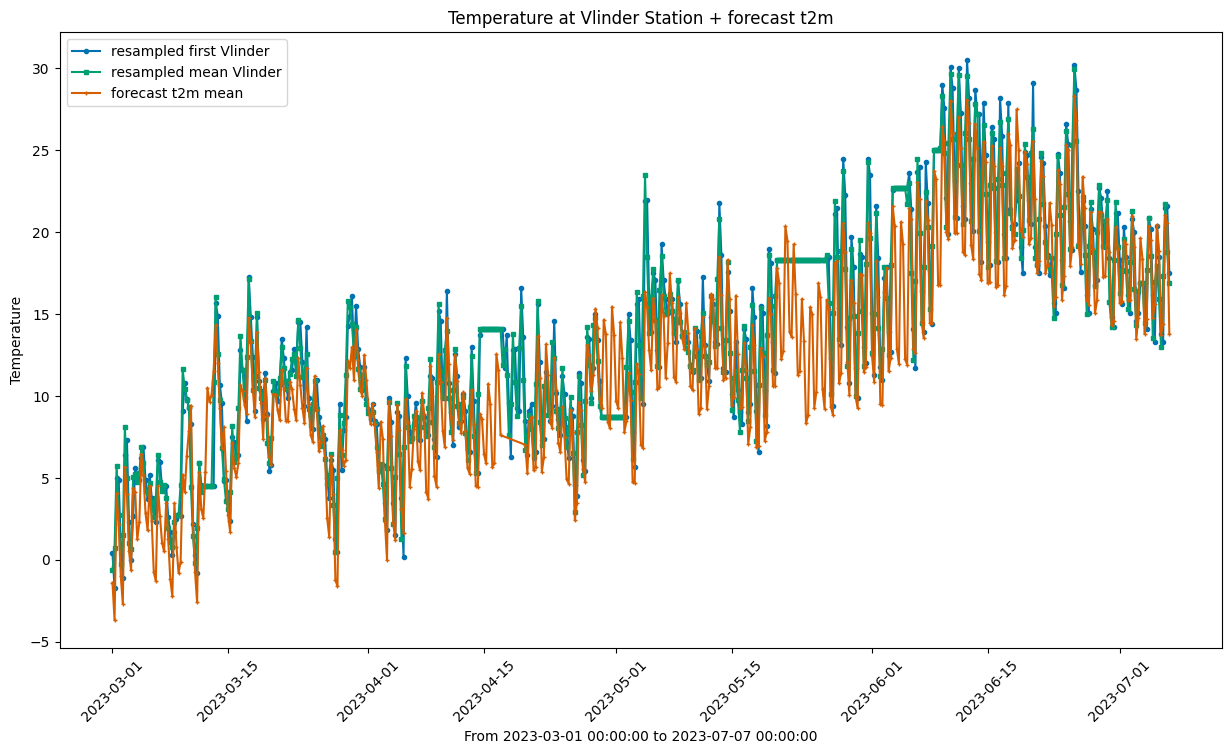

In [6]:
target = 't2m'

ensmean_forecast = forecast_data.get_df().groupby('time')[target].mean().reset_index()
ensmean_forecast[target] = ensmean_forecast[target] - Const_Conversion[target]
ensmean_forecast['time'] = pd.to_datetime(ensmean_forecast['time'])
ensmean_min, ensmean_max = forecast_data.get_min_max()


resample_select = vlinder_data.apply_dates_resize(ensmean_min, ensmean_max)
vlinder_fst = resample_select("first")
vlinder_mean = resample_select("mean")
plt.figure(figsize=(15, 8))
plt.plot(vlinder_fst[vlinder_data.time_str], vlinder_fst[vlinder_data.temp_str], marker='o', markersize=3, label='resampled first Vlinder')
plt.plot(vlinder_mean[vlinder_data.time_str], vlinder_mean[vlinder_data.temp_str], marker='s', markersize=3,label='resampled mean Vlinder')
plt.plot(ensmean_forecast['time'], ensmean_forecast[target], marker='+', markersize=3, label=f'forecast {target} mean')
plt.legend(loc='upper left')
plt.xlabel(f"""From {ensmean_min} to {ensmean_max}""")
plt.ylabel('Temperature')
plt.title(f'Temperature at Vlinder Station + forecast {target}')
plt.xticks(rotation=45)
plt.show()

We can see that around end March (from 03-22) we have missing forecast values, although this is not a probel for our forecasting

We need to decide whether the mean or the first value is the right choice when resampling our Vlinder Data.
We compute correlation between the mean temperature (t2m) in the forecasts and the temperature at the vlinder station.

In [7]:
#We drop the end of the vlinder data as data is wrong
resize_vlinder = vlinder_data.apply_dates_resize(forecast_min, forecast_max)

dropped_vlinder_mean = drop_unvalid_vlinder(resize_vlinder("mean"))
dropped_vlinder_first = drop_unvalid_vlinder(resize_vlinder("first"))

merge_p = partial(pd.merge, left_on=forecast_data.time_str, right_on=vlinder_data.time_str)
merged_df = merge_p(ensmean_forecast, dropped_vlinder_mean).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'mean'})
merged_df = merge_p(merged_df, dropped_vlinder_first).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'first'})

correlation_mean = merged_df['t2m'].corr(merged_df['mean'])
correlation_first = merged_df['t2m'].corr(merged_df['first'])

print(correlation_mean, correlation_first)

0.8746172146246272 0.9251958522790424


We can see that resampling on first value found in the interval has a higher correlation with our main target value 't2m'.

# Splitting Train, Validation and Test sets

As we want to train multiple models to see which has the best outcomes we want to split our data. We will do so by keeping ensemble forecasts together by starting data. Some ensemble forecast will be used to train the models, other to validate and a final ensemble forecast to do the final test.

# Dependencies Analysis

As our data is now merged, I will analyze dependencies between our feature variables (from the ensemble forecast) and our target variables (observed vlinder temperature)

In [8]:
def display_corr_matrix(df):
    corr_matrix = df.corr() 
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest') 
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.colorbar(label='Correlation')
    plt.show()


display_corr_matrix(df_fc_merged)

NameError: name 'df_fc_merged' is not defined

In [ ]:
correlations = df_fc_merged.corr()['vlinder_temp'].sort_values(ascending=False).drop('vlinder_temp')
correlations

Without surprise we can see from the correlation matrix that the features from the ensemble forecast that are highly correlated with the vlinder temperature are those measuring some kind of temperature (t2m, d2m, mx2t6, mn2t6,..). However those variables are also heavily cross-correlated, which means that we might want to drop them later. 

Latitude and longitude are constant values that hold no explicative power, we will drop them later

We also need to check for NaN values.


In [ ]:
#Display columns that have NaN values and percentage of NaN values
def nan_info(df):
    for column in which_col_nan(df):
        nan_percent = get_nan_percent(df[column], df.shape[0])
        print(f"{column} has {nan_percent * 100:.2f} % of NaN values" )
        
#Returns list of Columns that have nan values
def which_col_nan(df):
    return df.columns[df.isna().any()].tolist()

def get_nan_percent(df_col, df_entries):
    return df_col.isna().sum() / df_entries

nan_info(df_fc_merged)

We can see that cin has a large amount of NaN values and mx2t6 and mn2t6 have smaller amount, we will definitevely drop cin, but we could extrapolate mx2t6 if they appear to be interesting

In [ ]:
# Returns list of columns who have a number of unique features = 1 (=> all the same values)
# from https://studymachinelearning.com/pandas-how-to-remove-dataframe-columns-with-constant-same-values/
def constant_value_features_columns(df):
    return [e for e in df.columns if df[e].nunique() == 1]

def remove_cst_values(df):
    to_keep = [e for e in df.columns if e not in constant_value_features_columns(df)]
    return df[to_keep]

# Drop all columns that have NaN values or that are constant.
df_fc_merged.dropna(axis=1, how='any', inplace=True)
df_fc_merged = remove_cst_values(df_fc_merged)
df_fc_merged

# Spliting train, validation and test data

When creating our different sets, if we randomly split our data we also separate a given ensemble forecast into our different sets.

We need a special function that rounds up the the 50th closest observation to keep ensemble forecasts together in each set. 
At the moment we select a given percentage and round up to the closest value that is a multiple of 50, that way we get only whole ensemble forecasts.
We also need to select only from a given date onwards, this means that our test set is at one end of our set.

In [ ]:
y = df_fc_merged['vlinder_temp']

#TODO might need to keep datetime for later use
#We need to drop datetime to call fit_tranform
X = df_fc_merged.drop(columns=['vlinder_temp', 'datetime'])

In [ ]:
from sklearn.model_selection import train_test_split

# Function used to round up to the 50th closest value to avoid splitting different samples
# Returns number of entries to select
def get_nb_entries(df, percent):
    return math.floor(df.shape[0] * percent / 50) * 50

# With shuffle=False we use only the end -> the entries at the end is split if we take a "random" percentage
# We need to round up to a percentage that keeps time stamp whole
# Split the training set into new training and validation sets (~ 80% training, ~20% test)
nb_test_entries = get_nb_entries(X, 0.8)
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, train_size=nb_test_entries, shuffle=False)

# Split the training set into new training and validation sets (~75% training, ~25% validation)
nb_validation_entries = get_nb_entries(X_train_tmp, 0.75)
X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, train_size=nb_validation_entries, shuffle=False)
X_train.to_csv('tmp.csv')

In [ ]:
#TODO, scale or not ?
#Need to scale the data 
#from sklearn.preprocessing import StandardScaler 

#scaler_x = StandardScaler().fit(X_train)
#X_scale = scaler_x.transform(X_train)

In [ ]:
# TODO: automate to select the best k
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

#TODO probably need to drop highly cross related values -> Multicolineraty (not really as they measure the same thing)
#At what treshhold should i throw out values?
# Do we use multiple factor regression?
selector = SelectKBest(k=1, score_func=f_regression)
X_selected = selector.fit_transform(X_train.values, y_train.values)
cols_idxs = selector.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]
print(features_df_new)

# Simple solution

"Least-squares regression is applied on training data to estimate a linear relationship between predictions and corresponding observations" from _Vannitsem, S., Wilks, D. S., & Messner, J. W. (Elsevier). (2018). Statistical Postprocessing of Ensemble Forecasts_

We build a set with $tmp_{observed}$, $tmpfc_{1},\ \ldots, \ tmpfc_{50}$, data, ensemble mean and ensemble sdd

In [ ]:
# returns set that contains observed temperatures, forecast temperatures, ensemble mean and ensemble ssd 
def aggregate_transpose(df):
    df = df[['t2m', 'datetime']]
    # groups t2m entries in one datetime entry
    df_datetime = df.groupby('datetime').apply(lambda x: x.reset_index(drop=True))
    #creating one column entry per t2m value
    df_unstacked = df_datetime.unstack()
    #dropping datetime as group by has been done
    df_unstacked.drop(columns='datetime', inplace=True)
    return df_unstacked

df_simple_solution_transposed = aggregate_transpose(df_fc_merged)

#Insert vlinder temperatures into transposed dataframe, match data on datetime
df_vlinder_datetime_index = df_vlinder_res_first.set_index('datetime')
assert df_vlinder_datetime_index.index.equals(df_simple_solution_transposed.index), f"Indices (=> datetime) of transposed df and resampled vlinder should match\n GOT {df_vlinder_datetime_index.index}\n EXPECTED {df_simple_solution_transposed.index}"

df_simple_solution_transposed['ensmean'] = df_simple_solution_transposed.mean(axis=1)
df_simple_solution_transposed['enssd'] = df_simple_solution_transposed.std(axis=1)
df_simple_solution_transposed['temp_vlinder'] = df_vlinder_datetime_index[:]

#df_simple_solution = pd.concat([df_vlinder_datetime_index, df_simple_solution_transposed], axis=1)
#df_simple_solution.rename(columns={'temp': 'temp_vlinder', inplace=True)
df_simple_solution_transposed['temp_vlinder'] = df_simple_solution_transposed['temp_vlinder'] + C_0
df_simple_solution = df_simple_solution_transposed

In [ ]:
x = np.linspace(min(df_simple_solution['ensmean'] - C_0), max(df_simple_solution['ensmean'] - C_0))
y = x

plt.scatter(df_simple_solution['ensmean'] - C_0, df_simple_solution['temp_vlinder'] - C_0, marker='o')
plt.plot(x , y, linestyle='--', color='blue', label='x = y')
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Temperature observations by corresponding ensemble mean forecasts')
plt.show()

We can see that we have a negative bias in our ensemble forecast as most of our data points are above the x = y line

In [ ]:
X = df_simple_solution['ensmean'].values.reshape(-1, 1)
y = df_simple_solution['temp_vlinder'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from codecarbon import EmissionsTracker

def train_model(model, X_train, y_train, tracker):
    tracker.start()
    try:
        model.fit(X_train, y_train)
    finally:
        tracker.stop()
    return model

@track_emissions()
def train_model_2(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

tracker = EmissionsTracker()

#model = train_model(LinearRegression(), X_train, y_train, tracker)
model = train_model_2(LinearRegression(), X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficients:", model.coef_)

# Print the mean squared error
print("Mean squared error:", mean_squared_error(y_test, y_pred))

# Print the coefficient of determination (R^2 score)
print("Coefficient of determination (R^2 score):", r2_score(y_test, y_pred))

When selecting only one week our result are less precise as above
**!!! Conclusion drawn from test set as both have not been conducted in parrallel**

We need to take only one week with LOOCV and compare it to the whole data set with LOOCV

Linear Regression if only one week is selected
- Coefficients: [[0.76954526]]
- Mean squared error: 3.2674047991823643
- Coefficient of determination (R^2 score): 0.691794647528979


In [ ]:
plt.scatter(df_simple_solution['ensmean'] - C_0, df_simple_solution['temp_vlinder'] - C_0, marker='o')
plt.plot(X_test - C_0, y_pred - C_0, color='red', label='regression')
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Temperature observations by corresponding ensemble mean forecasts')
plt.show()

# Correcting forecast

In [ ]:
import re

def keep_digits(str):
    pattern = r'\D+' 
    return re.sub(pattern, '', str)

input_csv = "Forecast_16_03_2024.csv"
to_digits = keep_digits(input_csv)
output_csv_str = "Corr-" + to_digits[4:] + to_digits[2:4] + to_digits[:2] + "_TheBlaze.csv"
to_correct = pd.read_csv(f"weekly_forecast/{input_csv}")
to_correct = to_correct[['time', 'number', 't2m']]

to_correct.rename(columns={'time': 'datetime'}, inplace=True)
transposed = aggregate_transpose(to_correct)
transposed.reset_index(inplace=True)
transposed_datetime = transposed['datetime']
transposed.drop(columns='datetime', inplace=True)

df_corrected_t2m = transposed.copy()
for index, row in df_corrected_t2m.iterrows(): 
    y_row = model.predict(row.values.reshape(-1, 1))
    #squeeze to reshap np array into one dimension
    df_corrected_t2m.iloc[index] = np.squeeze(y_row)

df_corrected_t2m['datetime'] = transposed_datetime
df_corrected_t2m.set_index('datetime', inplace=True)


In [ ]:
print(to_correct[['datetime', 't2m']])

# reshapes corrected temperatures values to have same format as to_correct
df_reshaped = df_corrected_t2m.T.melt(var_name='datetime', value_name='t2m')

to_correct['t2m'] = df_reshaped['t2m']

df_corrected = to_correct

df_corrected.rename(columns={"datetime": "time"}, inplace=True)


df_corrected.to_csv(f"weekly_corrected/{output_csv_str}")

# Tests of CodeCarbon
Synthetic neural network, used to check power consumption using CodeCarbon packet

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Multi-layer Perceptron Classifier
clf = MLPClassifier(hidden_layer_sizes=(100, 5), activation='relu', solver='adam', max_iter=500, random_state=42)

train_model_2(clf, X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)